In [2]:
!pip install pymde emblaze gensim

In [3]:
import pandas as pd

df = pd.read_parquet('./work/data/hiscore_updates.parquet')

# retain only rows where mode=0
df = df[df['mode'] == 0]

# retain only rows where pp>=75
df = df[df['pp'] >= 75]

# drop columns:
# - mode
# - rank
# - is_classic
df = df.drop(columns=['mode', 'rank', 'is_classic'])

# convert types:
# user -> int32
# pp -> f32
# mods -> int32
df['user'] = df['user'].astype('int32')
df['pp'] = df['pp'].astype('float32')
df['mods'] = df['mods'].astype('int32')

print(f"Retained: {len(df)}")

df.head()

Retained: 30587537


,user,beatmap_id,score,pp,mods,score_time,update_time
275,55,48067,1631540,85.583900,0,2013-03-23 03:22:26,2022-11-20 15:17:13
276,55,48067,1631540,86.331703,0,2013-03-23 11:22:26,2017-02-01 13:30:30
278,55,116876,3484018,86.219597,0,2013-05-20 13:54:29,2022-11-20 15:17:13
279,55,116876,3484018,82.921402,0,2013-05-20 21:54:29,2017-02-01 13:30:30
280,55,102891,4221594,87.754799,0,2013-05-21 13:05:41,2022-11-20 15:17:13


In [4]:
"""
We only care about the following mods:
 - DT or NC -> DT
 - HD
 - EZ
 - HR
 - HT
 - FL

And we return them as a concatenated string in alphabetical order (e.g. "DTFLHR")
"""
def decode_mods_bitset(bitset: int):
    mods = ''
    if bitset & (1 << 6):
        mods += 'DT'
    if bitset & (1 << 1):
        mods += 'EZ'
    if bitset & (1 << 10):
        mods += 'FL'
    # if bitset & (1 << 3):
    #     mods += 'HD'
    if bitset & (1 << 4):
        mods += 'HR'
    if bitset & (1 << 8):
        mods += 'HT'

    return mods

# Apply the function to the 'mods' column
df['mods'] = df['mods'].apply(decode_mods_bitset)

In [5]:
df['score_id'] = df['beatmap_id'].astype(str) + '_' + df['mods'].astype(str)

In [6]:
# pre-sort the hiscores df by (user ascending, score_id ascending, update_time descending)
df.sort_values(by=['user', 'score_id', 'update_time'], ascending=[True, True, False], inplace=True)

# retain only the top pp score for each user+score_id
df = df.drop_duplicates(subset=['user', 'score_id'], keep='first')

In [7]:
user_counts = df.groupby('score_id')['user'].nunique()
user_counts.head()

score_id
1000052_DTHR     3
1000075_         3
1000075_DT       1
1000168_        62
1000168_HR       3
Name: user, dtype: int64

In [8]:
# find all unique score IDs by user id=4093752 and dump to csv
user_scores = df[df['user'] == 4093752]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/my_score_ids.csv', index=False)

# same for 3637436
user_scores = df[df['user'] == 3637436]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/blankz_score_ids.csv', index=False)

# same for 35452149
user_scores = df[df['user'] == 35452149]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/big_tomas_score_ids.csv', index=False)

# same for 32290754
user_scores = df[df['user'] == 32290754]
unique_scores = user_scores['score_id'].unique()
unique_scores_df = pd.DataFrame(unique_scores, columns=['score'])
unique_scores_df.to_csv('./work/data/peblohh_score_ids.csv', index=False)

In [8]:
# dump some extra metadata about scores to csv:
#
# - score_id
# - average pp
# - number of unique users

score_metadata = df.groupby('score_id').agg(
    avg_pp=('pp', 'mean'),
    num_users=('user', 'nunique')
).reset_index()

score_metadata.to_csv('./work/data/score_metadata.csv', index=False)

# create dict for local use
avg_pp_by_score_id = score_metadata.set_index('score_id')['avg_pp'].to_dict()

In [9]:
# Count how many 'score_id' have exactly one unique user
single_user_score_ids = user_counts[user_counts == 1].count()

print(f"Number of 'score_id' with exactly one unique user: {single_user_score_ids}")

two_user_score_ids = user_counts[user_counts == 2].count()

print(f"Number of 'score_id' with exactly two unique users: {two_user_score_ids}")

three_user_score_ids = user_counts[user_counts == 3].count()

print(f"Number of 'score_id' with exactly three unique users: {three_user_score_ids}")

four_user_score_ids = user_counts[user_counts == 4].count()

print(f"Number of 'score_id' with exactly four unique users: {four_user_score_ids}")

# filter out scores with low user counts
#
# there are way fewer very high pp plays (>500) than there are low pp plays, so we want
# to be more strict when deciding whether to filter low pp plays
#
# Filter out scores with less than 50 unique users at pp=100 and below, and linearly scale
# the filter threshold down to 5 users at pp=500.
def should_retain(score_id):
    avg_pp = avg_pp_by_score_id[score_id]
    num_users = user_counts[score_id]

    edge0 = 100
    edge1 = 500
    activation = max(0, min(1, (avg_pp - edge0) / (edge1 - edge0)))
    # scale from [0, 1] to [50, 5]
    threshold = 50 - (50 - 5) * activation

    return num_users >= threshold

before_score_count = len(df)
# df = df[df['score_id'].isin(user_counts[user_counts >= 50].index)]
df = df[df['score_id'].apply(should_retain)]

print(f'Filtered scores from {before_score_count} -> {len(df)}')

Number of 'score_id' with exactly one unique user: 43566
Number of 'score_id' with exactly two unique users: 17238
Number of 'score_id' with exactly three unique users: 10231
Number of 'score_id' with exactly four unique users: 7130
Filtered scores from 25581060 -> 24830131


In [10]:
unique_scores = df['score_id'].unique()

# populate mapping from score id to index in the co-occurrence matrix
score_to_index = {score: i for i, score in enumerate(unique_scores)}

df['score_ix'] = df['score_id'].apply(lambda x: score_to_index[x]).astype('int32')

print(f"Unique score count: {len(unique_scores)}")

Unique score count: 32477


In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from numba import jit
import gc

def condense_matrices(main_csr, uniq_score_count, rows, cols, vals):
    coo = coo_matrix((vals, (rows, cols)), shape=(uniq_score_count, uniq_score_count), dtype=np.float32)
    main_csr += coo.tocsr()

    gc.collect()

    return main_csr

chunk_size = 100_000_000

@jit(nopython=True)
def fill_arrays(cur_scores: np.ndarray, cur_scores_pps: np.ndarray, cur_score_ix: int, rows: np.ndarray, cols: np.ndarray, vals: np.ndarray, arr_ix: int) -> int:
    for i in range(cur_score_ix - 1):
        score_i_ix = cur_scores[i]

        for j in range(i + 1, cur_score_ix):
            # compute weight based on relative pp difference
            #
            # 0% difference -> weight = 2
            # 25% difference -> weight = 1
            # 50% difference -> weight = 0
            # >50% difference -> weight = 0
            #
            # decreasing linearly from 1 to 0 as difference increases.  Anything over 50% difference is 0.
            pp_i = cur_scores_pps[i]
            pp_j = cur_scores_pps[j]
            max_pp = max(pp_i, pp_j)
            relative_diff = abs(pp_i - pp_j) / max_pp
            weight = 0 if relative_diff > 0.5 else (1 - (relative_diff / 0.5)) * 2

            if weight <= 0:
                continue

            score_j_ix = cur_scores[j]
            rows[arr_ix] = score_i_ix
            cols[arr_ix] = score_j_ix
            vals[arr_ix] = weight
            arr_ix += 1

            if arr_ix >= chunk_size:
                raise ValueError("Array index out of bounds")

    return arr_ix

def compute_cooccurrence_matrix(uniq_score_count: int, df: pd.DataFrame) -> csr_matrix:
    main_csr = csr_matrix((uniq_score_count, uniq_score_count), dtype=np.float32)

    # collect up chunks of matrix entries
    rows = np.ndarray(chunk_size, dtype=np.int32)
    cols = np.ndarray(chunk_size, dtype=np.int32)
    vals = np.ndarray(chunk_size, dtype=np.float32)
    arr_ix = 0

    cur_user_id = 0
    # re-use typed array for current user's scores
    cur_scores = np.ndarray(50000, dtype=np.int32)
    cur_scores_pps = np.ndarray(50000, dtype=np.float32)
    cur_score_ix = 0

    row_ix = 0
    for row in df.itertuples():
        if row_ix % 2000000 == 0:
            print(f"Processing row {row_ix} of {len(df)}")
            main_csr.sum_duplicates()
            print(f"Main CSR nnz: {main_csr.nnz}")

        user_id = row.user
        score_ix = row.score_ix
        pp = row.pp

        if cur_user_id != user_id:
            needed_space = (cur_score_ix * (cur_score_ix - 1)) // 2
            if needed_space + arr_ix >= chunk_size:
                main_csr = condense_matrices(main_csr, uniq_score_count, rows[:arr_ix], cols[:arr_ix], vals[:arr_ix])
                arr_ix = 0

            arr_ix = fill_arrays(cur_scores, cur_scores_pps, cur_score_ix, rows, cols, vals, arr_ix)

            cur_user_id = user_id
            cur_scores[0] = score_ix
            cur_scores_pps[0] = pp
            cur_score_ix = 1
        else:
            cur_scores[cur_score_ix] = score_ix
            cur_scores_pps[cur_score_ix] = pp
            cur_score_ix += 1

        row_ix += 1

    print(f"final main CSR nnz: {main_csr.nnz}")

    return main_csr

In [12]:
cooccurrence_matrix = compute_cooccurrence_matrix(len(unique_scores), df)

Processing row 0 of 24830131
Main CSR nnz: 0
Processing row 2000000 of 24830131
Main CSR nnz: 28310368
Processing row 4000000 of 24830131
Main CSR nnz: 57928931
Processing row 6000000 of 24830131
Main CSR nnz: 70406891
Processing row 8000000 of 24830131
Main CSR nnz: 81073616
Processing row 10000000 of 24830131
Main CSR nnz: 90287034
Processing row 12000000 of 24830131
Main CSR nnz: 102862259
Processing row 14000000 of 24830131
Main CSR nnz: 110377748
Processing row 16000000 of 24830131
Main CSR nnz: 118116633
Processing row 18000000 of 24830131
Main CSR nnz: 126071814
Processing row 20000000 of 24830131
Main CSR nnz: 134099821
Processing row 22000000 of 24830131
Main CSR nnz: 141508260
Processing row 24000000 of 24830131
Main CSR nnz: 144771743
final main CSR nnz: 148080186


In [13]:
# symmetrize
sym_cooccurrence_matrix = (cooccurrence_matrix + cooccurrence_matrix.transpose()).tocsr()
print(f"Symmetrized co-occurrence matrix nnz: {sym_cooccurrence_matrix.nnz}")

Symmetrized co-occurrence matrix nnz: 296160372


In [14]:
# Now, we want to sparsify the matrix further by retaining only the top n co-occurrences for each score_id
#
# Since we've already symmetrized the matrix, we can just iterate over the rows, retain the top n co-occurrences,
# and build a new sparse matrix from that.  We also trim out any low-count co-occurrences.
#
# While we're at it, we also need to map the values from co-occurrence counts to a distance metric such that
# higher counts are closer to 0. We'll use the following formula:
#
# distance = 1 / log(count)

rows, cols, data = [], [], []

topn = 700
for row_ix in range(sym_cooccurrence_matrix.shape[0]):
    if row_ix % 1000 == 0:
        print(f"Processing row {row_ix} of {sym_cooccurrence_matrix.shape[0]}")

    row = sym_cooccurrence_matrix.getrow(row_ix)
    top_indices = np.argsort(row.data)[-topn:]
    # filter out low-count co-occurrences
    top_indices = top_indices[row.data[top_indices] > 2]
    rows.extend([row_ix] * len(top_indices))
    cols.extend(row.indices[top_indices])
    # mapped_data = -np.log(row.data[top_indices] / row.data.sum())
    mapped_data = np.reciprocal(np.log(row.data[top_indices]))
    data.extend(mapped_data)
    # data.extend(row.data[top_indices])
    # data.extend(np.ones(len(top_indices), dtype=np.float32))

top_cooccurrence_matrix = csr_matrix((data, (rows, cols)), shape=sym_cooccurrence_matrix.shape, dtype=np.float32)
print(f"Top co-occurrence matrix nnz: {top_cooccurrence_matrix.nnz}")

Processing row 0 of 32477
Processing row 1000 of 32477
Processing row 2000 of 32477
Processing row 3000 of 32477
Processing row 4000 of 32477
Processing row 5000 of 32477
Processing row 6000 of 32477
Processing row 7000 of 32477
Processing row 8000 of 32477
Processing row 9000 of 32477
Processing row 10000 of 32477
Processing row 11000 of 32477
Processing row 12000 of 32477
Processing row 13000 of 32477
Processing row 14000 of 32477
Processing row 15000 of 32477
Processing row 16000 of 32477
Processing row 17000 of 32477
Processing row 18000 of 32477
Processing row 19000 of 32477
Processing row 20000 of 32477
Processing row 21000 of 32477
Processing row 22000 of 32477
Processing row 23000 of 32477
Processing row 24000 of 32477
Processing row 25000 of 32477
Processing row 26000 of 32477
Processing row 27000 of 32477
Processing row 28000 of 32477
Processing row 29000 of 32477
Processing row 30000 of 32477
Processing row 31000 of 32477
Processing row 32000 of 32477
Top co-occurrence matri

In [15]:
import pymde

import numpy as np
import matplotlib.pyplot as plt

cooccurrence_graph = pymde.preprocess.Graph(top_cooccurrence_matrix)

In [23]:
n_neighbors = 12
embedding_dim = 3

mde = pymde.preserve_neighbors(
    cooccurrence_graph,
    # shortest_path_graph,
    embedding_dim=embedding_dim,
    attractive_penalty=pymde.penalties.Linear,
    # repulsive_penalty=None,
    verbose=True,
    # max_distance=1.2,
    n_neighbors=n_neighbors,
    init="random",
    # device='cuda'
)

Apr 25 12:32:27 AM: Computing 12-nearest neighbors, with max_distance=1.218959093093872
Apr 25 12:32:27 AM: Computing shortest path distances (retaining 100.00 percent with max_distance=1.218959093093872) ...
Apr 25 12:32:27 AM: Graph is weighted ... using slow path.
Apr 25 12:32:35 AM: processed node 1/32477


In [ ]:
# mde.constraint = pymde.constraints.Standardized()
# mde.distortion_function.attractive_penalty = pymde.penalties.Log1p(mde.distortion_function.attractive_penalty.weights)

In [ ]:
embedding = mde.embed(verbose=True, max_iter=2000, print_every=50)

Apr 25 12:28:19 AM: Fitting a centered embedding into R^3, for a graph with 32477 items and 1141092 edges.
Apr 25 12:28:19 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10


Apr 25 12:28:19 AM: iteration 0000 | distortion 1.258602 | residual norm 0.0109645 | step length 550.45 | percent change 1.92985
Apr 25 12:28:21 AM: iteration 0050 | distortion 0.538000 | residual norm 0.00267073 | step length 1 | percent change 2.16727
Apr 25 12:28:23 AM: iteration 0100 | distortion 0.355243 | residual norm 0.0019212 | step length 1 | percent change 2.85537
Apr 25 12:28:26 AM: iteration 0150 | distortion 0.326127 | residual norm 0.00102569 | step length 1 | percent change 0.517624
Apr 25 12:28:29 AM: iteration 0200 | distortion 0.321371 | residual norm 0.000680564 | step length 1 | percent change 0.153614
Apr 25 12:28:31 AM: iteration 0250 | distortion 0.319760 | residual norm 0.000550896 | step length 1 | percent change 0.189002
Apr 25 12:28:34 AM: iteration 0300 | distortion 0.318489 | residual norm 0.000486067 | step length 1 | percent change 0.331321
Apr 25 12:28:36 AM: iteration 0350 | distortion 0.317665 | residual norm 0.000478978 | step length 1 | percent chan

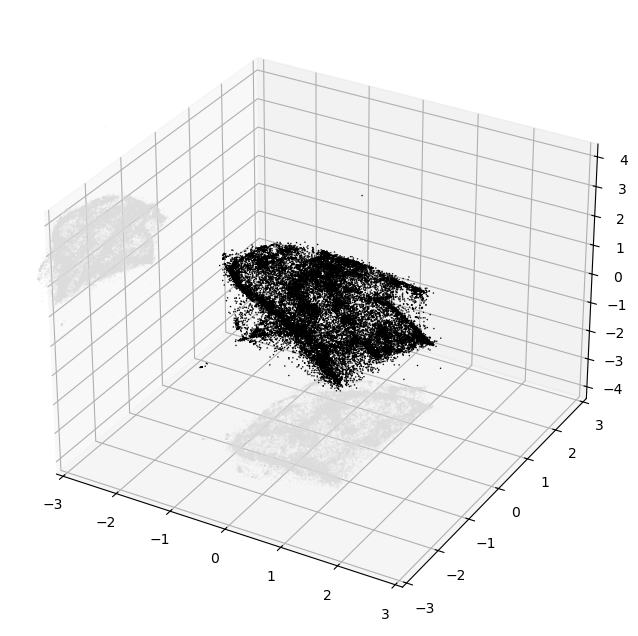

In [ ]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [ ]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n_bigger.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(embedding), mde.embedding_dim))
    for i in range(len(embedding)):
        row = embedding[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_3d_18n_bigger.w2v'

In [ ]:
# write dataframe mapping score_id to index
mapping = [(score_id, i) for score_id, i in score_to_index.items()]
mapping_df = pd.DataFrame(mapping, columns=['score_id', 'index'])
mapping_df.to_csv(f'{fname}.csv', index=False)
mapping_df.head()

# code to load:
# mapping_df = pd.read_csv('./work/data/score_id_mapping.csv')
# score_id_by_ix = mapping_df.set_index('index')['score_id'].to_dict()

,score_id,index
0,1007525_,0
1,1057659_,1
2,1089041_,2
3,109479_,3
4,112583_,4
